In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

## Introduction

For my dataset I will be using this [Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data), which contains anonymized data on over 5000 patients, with measurements for several potential risk factors for strokes. These meaurements include everything from BMI, history of heart disease, and marital status, among other things. I'm interested in taking a look at these and seeing which might be most relevant.

In [52]:

df = pd.read_csv("stroke prediction/healthcare-dataset-stroke-data.csv", index_col="id")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB
None


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Preparing the Data

For the most part, the data requires very little clean up to use. The biggest wrinkle is the **ever_married** column, which is clearly sthe same kind of boolean data like **hypertension**, **heart_disease**, and **stroke**, but it's recorded like a categorical column with values of *yes* or *no*, in stead of as a numerical column with values of 0 or 1 like those are. Let's convert all of those to booleans. 

In [53]:
df["ever_married"] = df["ever_married"].replace({"Yes": 1, "No": 0}).infer_objects(copy=False)
df["hypertension"] = df["hypertension"].astype(bool)
df["heart_disease"] = df["heart_disease"].astype(bool)
df["stroke"] = df["stroke"].astype(bool)

C:\Users\emmaf\AppData\Local\Temp\ipykernel_30064\1602691887.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ever_married"] = df["ever_married"].replace({"Yes": 1, "No": 0}).infer_objects(copy=False)


Here is a complete list of the measurements in this dataset:

- **gender**: Categorical, possible values of "Male", "Female" or "Other"
- **age**: Numeric, age of the patient
- **hypertension**: Boolean, False if the patient doesn't have hypertension, True if the patient has hypertension
- **heart_disease**: Boolean, False if the patient doesn't have any heart diseases, True if the patient has a heart disease
- **ever_married**: Boolean, True if the patient has ever been married in their life, False if not
- **work_type**: Categorial, possible values of "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- **Residence_type**: Categorial, possible values of "Rural" or "Urban"
- **avg_glucose_level**: Numeric, average glucose level in blood
- **bmi**: Numeric, body mass index
- **smoking_status**: Categorial, possible values of "formerly smoked", "never smoked", "smokes" or "Unknown"
- **stroke**: Boolean, True if the patient had a stroke or False if not

Of these, **stroke** is the most relevant, as it is our response variable. The rest we can sort into two basic groups: numeric variables, and categorical ones (including booleans). 

## Exploratory Data Analysis

When we graph the number of patients who have had strokes vs the number who haven't, we immediately see that the number of stroke patients in this dataset is vastly outnumbered by the number of no-stroke patients. We will need to take this into account going forward, such a small population may skew our data.

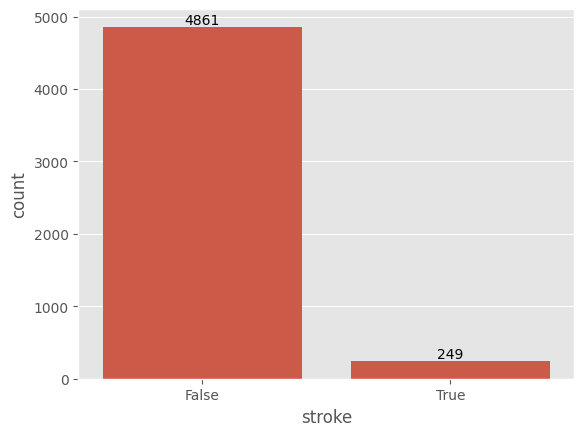

In [63]:
ax = sns.countplot(data=df, x="stroke")
ax.bar_label(ax.containers[0], fontsize=10)

plt.show()

Next, let's take each of our numerical variables, and compare their distributions between the stroke and no-stroke populations.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


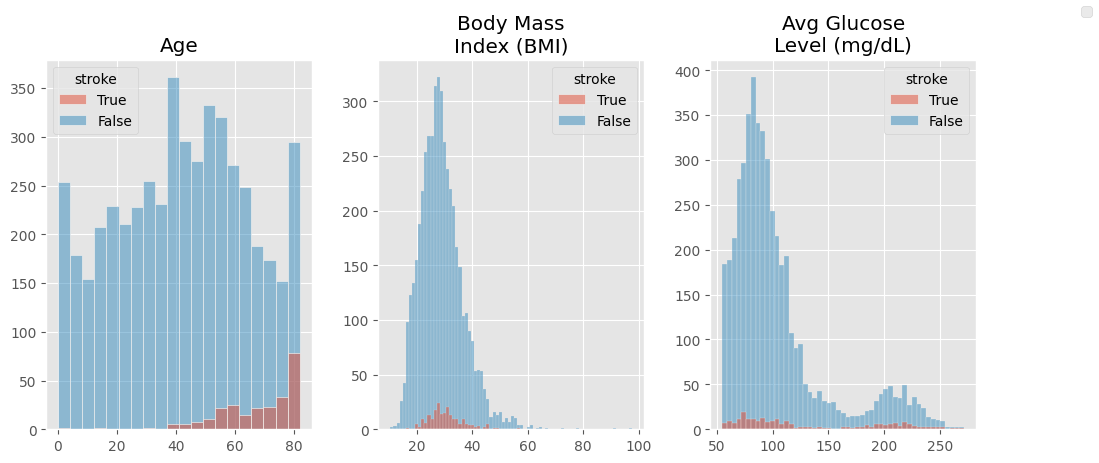

In [ ]:
df = df.sort_values(by="stroke", ascending=True)
order = [True, False]

fig, axs = plt.subplot_mosaic(mosaic=[["left", "center", "right"]])

sns.histplot(data=df, x="age", hue="stroke", hue_order=order, ax=axs["left"])
axs["left"].set_title('Age')

sns.histplot(data=df, x="bmi", hue="stroke", hue_order=order, ax=axs["center"])
axs["center"].set_title('Body Mass\nIndex (BMI)')

sns.histplot(data=df, x="avg_glucose_level", hue="stroke", hue_order=order, ax=axs["right"])
axs["right"].set_title('Avg Glucose\nLevel (mg/dL)')

for pos in axs:
    axs[pos].set_xlabel(None)
    axs[pos].set_ylabel(None)

fig.set_figwidth(12)
fig.subplots_adjust(wspace=0.25)
# fig.legend(loc="outside upper right")

Immediately, we can see a difference: while the distributions for BMI and glucose level are roughly parallel for the stroke and no-stroke samples, this is clearly not the case with age. For the no-stroke group, the distribution of age is roughly normal, with perhaps a slight skew to the left. The stroke group, on the other hand, is *highly* skewed to the left, with almost no one below the age of 40 and a sharp increase near the maximum age in the sample. Therefore **age** warrants more investigation as a possible contributing factor. 